# Import library

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_text as text
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel, BertTokenizer, BertModel
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dropout, Dense, BatchNormalization

2025-12-20 00:27:09.075961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766190429.273812      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766190429.332333      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766190429.795038      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766190429.795082      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766190429.795085      24 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Running on GPU: {gpus[0]}")
    except RuntimeError as e:
        print(f"⚠️ GPU Error: {e}")
else:
    print("⚠️ No GPU found, using CPU.")


✅ Running on GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#   Load the Dataset

In [3]:
df = pd.read_csv("/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv")

# Preprocess the Data

In [4]:
# Count words in each cell
word_counts = df.applymap(lambda x: len(str(x).split()))

total_words = word_counts.sum().sum()
print("\nTotal words in the dataset:", total_words)

df = df.drop_duplicates()

/tmp/ipykernel_24/2655070834.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_counts = df.applymap(lambda x: len(str(x).split()))



Total words in the dataset: 21682325


In [5]:
# Convert labels to integers
df['label'] = df['label'].astype(int)

# Convert `content` to string (avoid tokenizer errors)
df['content'] = df['content'].astype(str)

df.label.value_counts()

label
1    166844
0    163124
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42)

X_train = X_train.tolist()  
X_test = X_test.tolist()

# Use a BERT Model to Embed the Data

In [7]:
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_bert_embeddings(texts, max_length=100, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {k: v.to("cuda", non_blocking=True) for k, v in inputs.items()}  
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)


model.to("cuda")  

# Generate embeddings for training and testing data
train_embeddings = get_bert_embeddings(X_train)  
test_embeddings = get_bert_embeddings(X_test)

print(f"Train Embeddings Shape: {train_embeddings.shape}")  
print(f"Test Embeddings Shape: {test_embeddings.shape}")  

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Train Embeddings Shape: (263974, 768)
Test Embeddings Shape: (65994, 768)


In [8]:
torch.save(torch.tensor(train_embeddings), "train_embeddings.pt")
torch.save(torch.tensor(test_embeddings), "test_embeddings.pt")

train_embeddings = torch.load("train_embeddings.pt").numpy()
test_embeddings = torch.load("test_embeddings.pt").numpy()

train_embeddings = train_embeddings.reshape(-1, 1, 768)  
test_embeddings = test_embeddings.reshape(-1, 1, 768)

# Define Settings to train the models

In [9]:
LR = 1e-4
EPOCHS = 10
BATCH_SIZE = 64
DROPOUT = 0.3

# Build RNN model

In [10]:
rnn_model = Sequential([
    SimpleRNN(128, input_shape=(1, 768), return_sequences = True),  
    BatchNormalization(), 
    Dropout(DROPOUT),  
    
    SimpleRNN(64, return_sequences = False),  
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(128, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(64, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(1, activation="sigmoid") 
])

#  Compile model with improved optimizer
rnn_model.compile(
    optimizer=Adam(learning_rate = LR), 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

rnn_model.summary()

I0000 00:00:1766191817.156174      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14821 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 128)         │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,577 (564.75 KB)

 Trainable params: 144,193 (563.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
rnn_model.fit(train_embeddings,
              y_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              validation_data = (test_embeddings, y_test),
              verbose = 1)

Epoch 1/10


I0000 00:00:1766191824.522457      87 service.cc:152] XLA service 0x7afe640a68b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766191824.522507      87 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766191825.237086      87 cuda_dnn.cc:529] Loaded cuDNN version 91002


  53/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5402 - loss: 0.7795

I0000 00:00:1766191828.118933      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4125/4125 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.7983 - loss: 0.4326 - val_accuracy: 0.8804 - val_loss: 0.2839
Epoch 2/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8707 - loss: 0.3148 - val_accuracy: 0.8824 - val_loss: 0.2769
Epoch 3/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8769 - loss: 0.2998 - val_accuracy: 0.8853 - val_loss: 0.2702
Epoch 4/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8780 - loss: 0.2927 - val_accuracy: 0.8866 - val_loss: 0.2686
Epoch 5/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8805 - loss: 0.2894 - val_accuracy: 0.8882 - val_loss: 0.2641
Epoch 6/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8826 - loss: 0.2841 - val_accuracy: 0.8896 - val_loss: 0.2625
Epoch 7/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8855 - loss: 0.2786 - val_accuracy: 0.8892 - val_loss: 0.2664
Epoch 8/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8866 - loss: 0.2770 - val

In [12]:
rnn_model_loss,rnn_model_accuracy = rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {rnn_model_accuracy:.4f}")

2063/2063 - 5s - 2ms/step - accuracy: 0.8920 - loss: 0.2569
Test Accuracy: 0.8920


In [13]:
y_pred = (rnn_model.predict(test_embeddings) > 0.5).astype(int)


print(classification_report(y_test, y_pred))

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     32583
           1       0.89      0.90      0.89     33411

    accuracy                           0.89     65994
   macro avg       0.89      0.89      0.89     65994
weighted avg       0.89      0.89      0.89     65994



 # Build LSTM model

In [14]:
lstm_model = Sequential([
    LSTM(128, input_shape=(1, 768), return_sequences=True),  
    BatchNormalization(),
    Dropout(DROPOUT), 
    
    LSTM(64, return_sequences=False),  
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(128, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(64, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(1, activation="sigmoid")  
])

# Compile model with improved optimizer
lstm_model.compile(
    optimizer=Adam(learning_rate=LR), 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,081 (2.01 MB)

 Trainable params: 525,697 (2.01 MB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
history = lstm_model.fit(
    train_embeddings, y_train,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_data = (test_embeddings, y_test),
    verbose=1)

Epoch 1/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 50s 11ms/step - accuracy: 0.8085 - loss: 0.4148 - val_accuracy: 0.8829 - val_loss: 0.2773
Epoch 2/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8726 - loss: 0.3081 - val_accuracy: 0.8857 - val_loss: 0.2718
Epoch 3/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8800 - loss: 0.2918 - val_accuracy: 0.8874 - val_loss: 0.2675
Epoch 4/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8825 - loss: 0.2853 - val_accuracy: 0.8890 - val_loss: 0.2690
Epoch 5/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8846 - loss: 0.2798 - val_accuracy: 0.8893 - val_loss: 0.2643
Epoch 6/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8851 - loss: 0.2776 - val_accuracy: 0.8908 - val_loss: 0.2601
Epoch 7/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8868 - loss: 0.2760 - val_accuracy: 0.8912 - val_loss: 0.2591
Epoch 8/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.8888 -

In [16]:
lstm_model_loss, lstm_model_accuracy = lstm_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {lstm_model_accuracy:.4f}")

2063/2063 - 7s - 3ms/step - accuracy: 0.8920 - loss: 0.2584
Test Accuracy: 0.8920


In [17]:
y_pred = (lstm_model.predict(test_embeddings) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     32583
           1       0.91      0.87      0.89     33411

    accuracy                           0.89     65994
   macro avg       0.89      0.89      0.89     65994
weighted avg       0.89      0.89      0.89     65994



# Build Bi Directional RNN model

In [18]:
bi_rnn_model = Sequential([
    Bidirectional(SimpleRNN(128, return_sequences=True), input_shape=(1, 768)),  
    BatchNormalization(), 
    Dropout(DROPOUT),  
    
    Bidirectional(SimpleRNN(64, return_sequences=False)),  
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(128, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(64, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(1, activation="sigmoid")  
])


bi_rnn_model.compile(
    optimizer=Adam(learning_rate = LR), 
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

bi_rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,089 (1.13 MB)

 Trainable params: 296,321 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
history = bi_rnn_model.fit(
    train_embeddings, y_train,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_data = (test_embeddings, y_test),
    verbose=1)

Epoch 1/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.8029 - loss: 0.4282 - val_accuracy: 0.8740 - val_loss: 0.2959
Epoch 2/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8735 - loss: 0.3107 - val_accuracy: 0.8840 - val_loss: 0.2732
Epoch 3/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8772 - loss: 0.2973 - val_accuracy: 0.8863 - val_loss: 0.2693
Epoch 4/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8803 - loss: 0.2875 - val_accuracy: 0.8890 - val_loss: 0.2639
Epoch 5/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8830 - loss: 0.2821 - val_accuracy: 0.8885 - val_loss: 0.2636
Epoch 6/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8863 - loss: 0.2749 - val_accuracy: 0.8879 - val_loss: 0.2656
Epoch 7/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8865 - loss: 0.2728 - val_accuracy: 0.8909 - val_loss: 0.2611
Epoch 8/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8882 - loss: 0

In [20]:
bi_rnn_model_loss, bi_rnn_model_accuracy = bi_rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {bi_rnn_model_accuracy:.4f}")

2063/2063 - 5s - 2ms/step - accuracy: 0.8926 - loss: 0.2575
Test Accuracy: 0.8926


In [21]:
y_pred = (bi_rnn_model.predict(test_embeddings) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     32583
           1       0.89      0.90      0.89     33411

    accuracy                           0.89     65994
   macro avg       0.89      0.89      0.89     65994
weighted avg       0.89      0.89      0.89     65994



# Bi-Directional LSTM model

In [22]:
bi_lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, 768)),  
    BatchNormalization(),  
    Dropout(DROPOUT), 
    
    Bidirectional(LSTM(64, return_sequences=False)),  
    BatchNormalization(),
    Dropout(DROPOUT),

    Dense(128, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(64, activation="relu"),
    Dropout(DROPOUT),
    
    Dense(1, activation="sigmoid")  
])


bi_lstm_model.compile(
    optimizer=Adam(learning_rate = LR),  
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

bi_lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,249 (4.23 MB)

 Trainable params: 1,108,481 (4.23 MB)

 Non-trainable params: 768 (3.00 KB)

In [23]:
history = bi_lstm_model.fit(
    train_embeddings, y_train,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,  
    validation_data = (test_embeddings, y_test),
    verbose=1
)

Epoch 1/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - accuracy: 0.8192 - loss: 0.4029 - val_accuracy: 0.8822 - val_loss: 0.2797
Epoch 2/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 54s 13ms/step - accuracy: 0.8757 - loss: 0.3018 - val_accuracy: 0.8800 - val_loss: 0.2863
Epoch 3/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - accuracy: 0.8798 - loss: 0.2887 - val_accuracy: 0.8877 - val_loss: 0.2674
Epoch 4/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.8832 - loss: 0.2832 - val_accuracy: 0.8888 - val_loss: 0.2635
Epoch 5/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.8853 - loss: 0.2768 - val_accuracy: 0.8911 - val_loss: 0.2612
Epoch 6/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.8892 - loss: 0.2702 - val_accuracy: 0.8919 - val_loss: 0.2595
Epoch 7/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.8902 - loss: 0.2683 - val_accuracy: 0.8933 - val_loss: 0.2564
Epoch 8/10
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - accuracy: 0.8915 -

In [24]:
bi_lstm_model_loss, bi_lstm_model_accuracy = bi_lstm_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {bi_lstm_model_accuracy:.4f}")

2063/2063 - 8s - 4ms/step - accuracy: 0.8942 - loss: 0.2539
Test Accuracy: 0.8942


In [25]:
y_pred = (bi_lstm_model.predict(test_embeddings) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     32583
           1       0.90      0.89      0.89     33411

    accuracy                           0.89     65994
   macro avg       0.89      0.89      0.89     65994
weighted avg       0.89      0.89      0.89     65994



# Comparing RNN, LSTM, Bi-RNN, and Bi-LSTM

/tmp/ipykernel_24/3299880555.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='tab10')


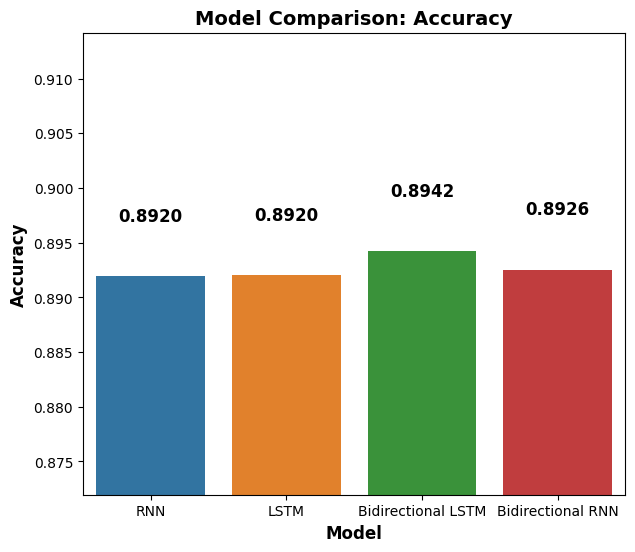

In [26]:
model_results = {
    'RNN': {'Accuracy': rnn_model_accuracy, 'Loss': rnn_model_loss},
    'LSTM': {'Accuracy': lstm_model_accuracy, 'Loss': lstm_model_loss},
    'Bidirectional LSTM': {'Accuracy': bi_lstm_model_accuracy, 'Loss': bi_lstm_model_loss},
    'Bidirectional RNN': {'Accuracy': bi_rnn_model_accuracy, 'Loss': bi_rnn_model_loss}
}

# Extract model names, accuracies, and losses for plotting
model_names = list(model_results.keys())
accuracies = [model_results[model]['Accuracy'] for model in model_names]
losses = [model_results[model]['Loss'] for model in model_names]

# Visualize accuracy comparison
plt.figure(figsize=(7, 6))
sns.barplot(x=model_names, y=accuracies, palette='tab10')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Comparison: Accuracy', fontsize=14, fontweight='bold')
plt.ylim(min(accuracies) - 0.02, max(accuracies) + 0.02)  

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.show()

/tmp/ipykernel_24/687778818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=losses, palette='rocket')


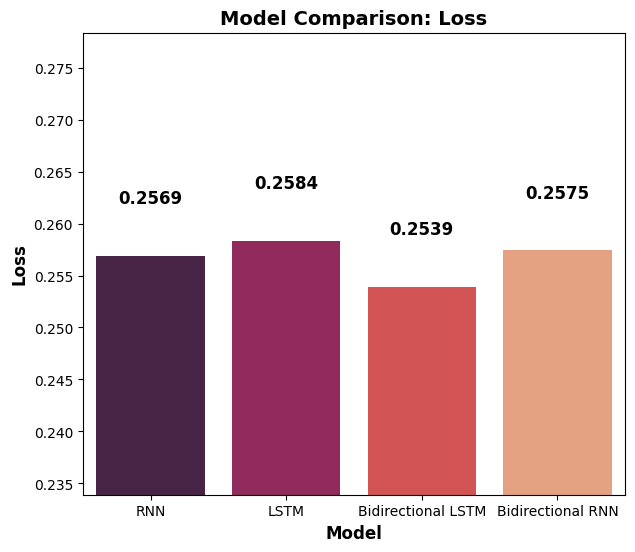

In [27]:
# Visualize loss comparison
plt.figure(figsize=(7, 6))
sns.barplot(x=model_names, y=losses, palette='rocket')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Model Comparison: Loss', fontsize=14, fontweight='bold')
plt.ylim(min(losses) - 0.02, max(losses) + 0.02)  

# Add loss values on top of each bar
for i, loss in enumerate(losses):
    plt.text(i, loss + 0.005, f"{loss:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.show()